In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = './res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name

plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

In [2]:
import sqlite3

import pandas as pd

from utils.timeutil import YearMonth
from core.repository import load_financial
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 3)
    end = YearMonth(2023, 7)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]
        df2.loc[df2["val_last"] == 0, "close"] = df2[df2["val_last"] == 0]["close"] / 2

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
            "전월수익률": df1["close"] / df1["open"] - 1
        })

        shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
        df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = layer1["확정실적"].apply(str)
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,거래대금,...,E_QoQ,R/A_QoQ,GP/A_QoQ,O/A_QoQ,E/A_QoQ,R/EQ_QoQ,GP/EQ_QoQ,O/EQ_QoQ,E/EQ_QoQ,확정실적
0,060310,3S,코스닥,2012-03,2012-04,800753636500,2012-03-30,20500,5134684,107562943550,...,2.244187,-0.031297,-0.005466,0.005344,0.014194,-0.202853,-0.049355,-0.009380,0.014303,2011-3Q
1,006840,AK홀딩스,유가증권,2012-03,2012-04,284800000000,2012-03-30,32000,795205,25993983200,...,-0.399875,0.005742,-0.017596,-0.015163,-0.010560,0.055238,-0.027063,-0.024840,-0.017450,2011-3Q
2,054620,APS,코스닥,2012-03,2012-04,281637726750,2012-03-30,13050,11700595,157564423900,...,12.251491,0.004313,0.019232,0.022591,0.010280,0.215688,0.068383,0.057678,0.026531,2011-3Q
3,126600,BGF에코머티리얼즈,코스닥,2012-03,2012-04,55680000000,2012-03-30,6400,2093665,11663607660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-3Q
4,138930,BNK금융지주,유가증권,2012-03,2012-04,2571952656700,2012-03-30,13300,14370897,200538992130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-3Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260679,189980,흥국에프엔비,코스닥,2023-06,2023-07,113790739545,2023-06-30,2835,5367732,16340191270,...,1.162015,-0.017821,-0.006023,0.005283,0.002922,0.039274,0.013537,0.017027,0.010228,2023-1Q
260680,000540,흥국화재,유가증권,2023-06,2023-07,202685544975,2023-06-30,3155,1283095,4085555555,...,NaN,-0.004562,NaN,0.006684,NaN,-1.129165,NaN,-0.004460,NaN,2023-1Q
260681,003280,흥아해운,유가증권,2023-06,2023-07,504892287900,2023-06-30,2100,159894770,327193558893,...,4.324908,0.044109,0.028347,0.020031,0.018313,0.058857,0.057952,0.041599,0.038572,2023-1Q
260682,037440,희림,코스닥,2023-06,2023-07,116948790000,2023-06-30,8400,5025556,45833419310,...,0.337451,-0.023639,-0.002336,-0.002773,0.001033,-0.011178,-0.000317,-0.005488,0.004401,2023-1Q


In [3]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출액": "R",
        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = [
    "BIS",
    "BIS_QoQ",
    "전월수익률",
    "E_YoY",
    "O_YoY"
]

for x in ["R", "GP", "O", "E"]:
    for y in ["", "/A", "/EQ"]:
        factors.append(f"{x}{y}_QoQ")

for pos in ["R", "GP", "O", "E", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["A", "EQ"]:
    for pos in ["R", "GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

layer2["TV/P"] = layer2["TV"] / layer2["P"]
factors.append("TV/P")

result = pd.DataFrame()

recipes = {
    "v3": {
        "P": -8,
        "GP/P": 4,
        "EQ/P": 4,
        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,
        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "성장_단순이익": {f"{e}_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자산대비이익": {f"{e}/A_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자본대비이익": {f"{e}/EQ_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_매출종합": {f"R{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_매출총이익종합": {f"GP{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_영업이익종합": {f"O{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_순이익종합": {f"E{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_YoY": {"E_YoY": 1, "O_YoY": 1},
    "성장": {
        "성장_매출총이익종합": 5,
        "성장_영업이익종합": 4,
        "성장_순이익종합": 3,
        "성장_매출종합": 2,
    },
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "v4": {
        "P": -1,
        "성장": 1,
        "벨류": 1,
    },
    "전략": {
        "v3": 1,
        "v4": 1
    }
}

print(pd.DataFrame(recipes))

for ym in layer2["매수년월"].unique():
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else -df[f"{k}_pct"] * abs(w) for k, w in recipe.items()])

        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = list(recipes.keys()) + factors
result

             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
R/EQ_QoQ    NaN      NaN        NaN        1.0      1.0         NaN   
GP/EQ_QoQ   NaN      NaN        NaN        1.0      NaN         1.0   
O/EQ_Q

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,TV,...,성장_YoY,성장_YoY_pct,성장,성장_pct,벨류,벨류_pct,v4,v4_pct,전략,전략_pct
0,060310,3S,코스닥,2012-03,2012-04,800753636500,2012-03-30,20500,5134684,107562943550,...,79.0,84.0,53.000000,55.0,1.0,1.0,-11.333333,6.0,5.5,5.0
1,006840,AK홀딩스,유가증권,2012-03,2012-04,284800000000,2012-03-30,32000,795205,25993983200,...,63.5,68.0,33.500000,28.0,62.0,64.0,3.666667,24.0,25.5,25.0
2,054620,APS,코스닥,2012-03,2012-04,281637726750,2012-03-30,13050,11700595,157564423900,...,37.5,33.0,93.071429,98.0,11.0,7.0,8.333333,33.0,30.5,30.0
3,126600,BGF에코머티리얼즈,코스닥,2012-03,2012-04,55680000000,2012-03-30,6400,2093665,11663607660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,138930,BNK금융지주,유가증권,2012-03,2012-04,2571952656700,2012-03-30,13300,14370897,200538992130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260679,189980,흥국에프엔비,코스닥,2023-06,2023-07,113790739545,2023-06-30,2835,5367732,16340191270,...,82.5,86.0,72.000000,77.0,55.5,56.0,30.000000,77.0,75.5,75.0
260680,000540,흥국화재,유가증권,2023-06,2023-07,202685544975,2023-06-30,3155,1283095,4085555555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260681,003280,흥아해운,유가증권,2023-06,2023-07,504892287900,2023-06-30,2100,159894770,327193558893,...,88.5,92.0,95.285714,98.0,21.0,16.0,10.333333,34.0,34.0,34.0
260682,037440,희림,코스닥,2023-06,2023-07,116948790000,2023-06-30,8400,5025556,45833419310,...,57.5,60.0,55.214286,57.0,43.0,41.0,18.000000,51.0,50.5,50.0


['v3', '성장_단순이익', '성장_자산대비이익', '성장_자본대비이익', '성장_매출종합', '성장_매출총이익종합', '성장_영업이익종합', '성장_순이익종합', '성장_YoY', '성장', '벨류', 'v4', '전략']
[13/13] 전략YoY종합합합
2012-03 2023-07
             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN  

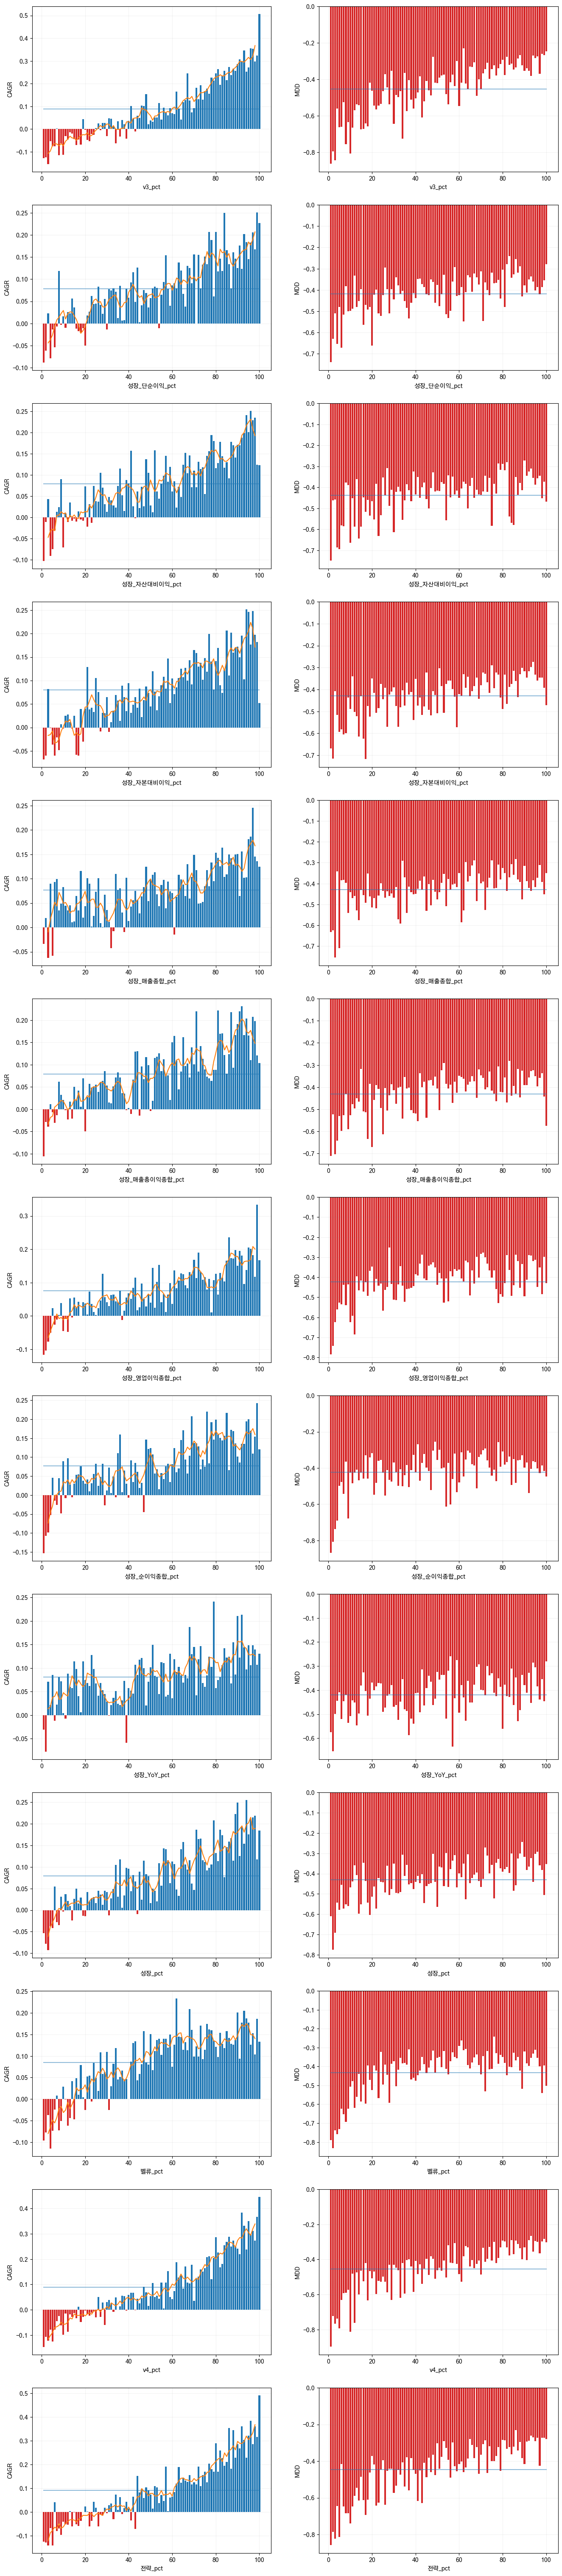

In [ ]:
from core.base.quantutil import cagr, mdd
from utils.timeutil import YearMonth
from datetime import date

# target_factors = [f for f in factors if "성장" in f]
target_factors = list(recipes.keys())
print(target_factors)

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    spearman = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname_pct]["cagr"],
            "kendall": kendall[colname_pct]["cagr"],

            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),

            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),

            "mdd5": mdd_by_pct_desc.head(5).mean(),

            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),

            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

In [ ]:
# 각 월에 전략에 의해 선정된 종목의 수익률이 과거 전략 매수에 의한 수익률과 어떤 관계를 갖는지 확인
# 결론: 의미 없는것 같음

search_result = result.copy()
search_result = search_result[search_result["전략_pct"] >= 99]
search_result = search_result[["code", "종목명", "매도년월", "전략_pct", "벨류_pct", "성장_pct", "수익률"]]


def historical_returns(row):
    selector = (search_result["매도년월"] < row["매도년월"]) & (search_result["code"] == row["code"])
    return (search_result[selector]["수익률"] + 1).prod()


# effect 는 선정된 각 종목의 과거 전략에 의한 수익률이다.
search_result["effect"] = search_result.apply(lambda row: historical_returns(row), axis=1)
search_result["벤치마크 수익률"] = (result.groupby("매도년월")["수익률"]).transform('mean')
search_result["성능"] = search_result["수익률"] - search_result["벤치마크 수익률"]
data = search_result.groupby("code")["성능"].mean()
print("out count", data[data > 0].count())
print("und count", data[data < 0].count())
print("out 성능평균", data[data > 0].mean())
print("und 성능평균", data[data < 0].mean())

In [ ]:
# 백테스트: 매매 시뮬레이션

from core.base.quantutil import cagr, mdd
from utils.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

head = 30
result2 = result.copy()
result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

# todo: 필터를 전 종목 기준으로 하지말고, 전략 내에서 해보자. 예를들면, 전월수익률

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", "전월수익률", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")

result3

In [ ]:
pd.concat([
    revisions,
    revisions["성능"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("성능 12개월"),
    revisions["전략 수익률"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("전략수익률 12개월")
], axis=1)

In [ ]:
from core.base.quantutil import cagr

revisions["month"] = revisions.index.to_series().apply(lambda x: x[0].split("-")[1])
return_by_month = pd.concat([
    revisions.groupby("month")["벤치마크 수익률"].apply(lambda x: cagr(1, (x + 1).prod(), len(x))),
    revisions.groupby("month")["전략 수익률"].apply(lambda x: cagr(1, (x + 1).prod(), len(x))),
], axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(4)
ax1.bar(return_by_month.index, return_by_month["벤치마크 수익률"])
ax1.set_title("월별 벤치마크 수익률")
ax2.bar(return_by_month.index, return_by_month["전략 수익률"])
ax2.set_title("월별 전략 수익률")
return_by_month

In [ ]:
import numpy as np

months = [i for _, i in strategy.index]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})